In [1]:
import os
os.chdir('..')
print(f'Current working directory is {os.getcwd()}')

Current working directory is c:\Users\blond\Documents\NssProjects\accre-green-bean-casserole


In [2]:
import pandas as pd
from scripts.get import log_to_df, df_to_datelist
from collections import Counter

import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
jobs = pd.read_csv("data/fullsample.csv")


In [4]:
jobs['BEGIN'] = pd.to_datetime(
    jobs['BEGIN'], 
    errors='coerce'
)
jobs['END'] = pd.to_datetime(
    jobs['END'], 
    errors='coerce'
)

C:\Users\blond\AppData\Local\Temp\ipykernel_15820\1972129250.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  jobs['END'] = pd.to_datetime(


In [5]:
# had to drop the na to get the drop to work
jobs = jobs.dropna(subset = 'END')

In [7]:
# assigning min and max timestamps to remove from the jobs dataframe.
min_timestamp = pd.to_datetime('2020-10-16 10:37:44.163454')
max_timestamp = pd.to_datetime('2021-10-07 20:41:11')

In [8]:
jobs = jobs.loc[jobs['END'] >=  min_timestamp]
jobs = jobs.loc[jobs['END'] <= max_timestamp]

In [9]:
jobs['END'].min()

Timestamp('2020-10-16 10:37:45')

In [10]:
jobs['END'].max()

Timestamp('2021-10-07 20:41:11')

In [11]:
ce5 = log_to_df('data/slurm_wrapper_ce5.log')
ce6 = log_to_df('data/slurm_wrapper_ce6.log')
error_list = df_to_datelist(ce6) + df_to_datelist(ce5)

In [12]:
len(error_list)

3296

In [13]:
# changing way doing the column for day/hour, then added ones for every 15, 30, 45 mins this is not doing what I wanted, I wanted rounded numbers, and this was not in the right intervals
# jobs['END'].dt.to_period('H')
# jobs['END'].dt.to_period('15T')
# jobs['END'].dt.to_period('30T')
# jobs['END'].dt.to_period('45T')
# df['date'].dt.to_period('H')


# this worked better but would need to change for each interval, and then also figure out how to match this to the errors list
# Group by 15-minute intervals
jobs_15min = jobs.set_index('END').groupby(pd.Grouper(freq='15min')).size().reset_index(name = 'JobEndCount')
jobs_30min = jobs.set_index('END').groupby(pd.Grouper(freq='30min')).size().reset_index(name = 'JobEndCount')
jobs_45min = jobs.set_index('END').groupby(pd.Grouper(freq='45min')).size().reset_index(name = 'JobEndCount')
jobs_60min = jobs.set_index('END').groupby(pd.Grouper(freq='60min')).size().reset_index(name = 'JobEndCount')




In [14]:
jobs_15min = jobs_15min.rename(columns={'END': 'end_group'})
jobs_30min = jobs_30min.rename(columns={'END': 'end_group'})
jobs_45min = jobs_45min.rename(columns={'END': 'end_group'})
jobs_60min = jobs_60min.rename(columns={'END': 'end_group'})

In [ ]:
jobs_60min.head()

In [15]:
# made this into a dataframe, going to group like the jobs and count how many errors are in each time grouping 
error_df = pd.DataFrame({'error_timestamp': error_list})

In [16]:
errors_15min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='15min')).size().reset_index(name = 'ErrorCount')
errors_30min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='30min')).size().reset_index(name = 'ErrorCount')
errors_45min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='45min')).size().reset_index(name = 'ErrorCount')
errors_60min = error_df.set_index('error_timestamp').groupby(pd.Grouper(freq='60min')).size().reset_index(name = 'ErrorCount')


In [17]:
errors_15min = errors_15min.rename(columns={'END': 'end_group'})
errors_30min = errors_30min.rename(columns={'END': 'end_group'})
errors_45min = errors_45min.rename(columns={'END': 'end_group'})
errors_60min = errors_60min.rename(columns={'END': 'end_group'})

In [ ]:
errors_15min.head()

In [18]:
job_errors_60min = (
    pd.merge(
        left = jobs_60min,    
        right = errors_60min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

In [19]:
job_errors_45min = (
    pd.merge(
        left = jobs_45min,    
        right = errors_45min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

In [20]:
job_errors_30min = (
    pd.merge(
        left = jobs_30min,    
        right = errors_30min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

In [21]:
job_errors_15min = (
    pd.merge(
        left = jobs_15min,    
        right = errors_15min,
        left_on = 'end_group',
        right_on = 'error_timestamp',
        how = 'left')
    .drop(columns = 'error_timestamp')
    )

In [22]:
job_errors_15min['ErrorCount'].value_counts()

ErrorCount
0.0     31853
1.0      1424
2.0       348
3.0       176
4.0        62
5.0        32
6.0        11
7.0         7
8.0         4
9.0         4
11.0        2
12.0        1
13.0        1
10.0        1
Name: count, dtype: int64

In [ ]:
job_errors_60min

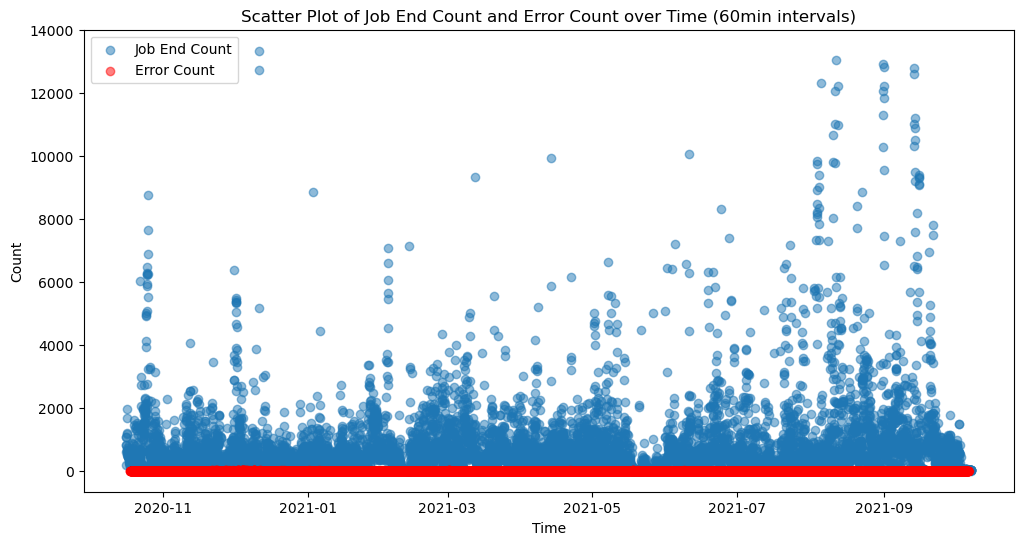

In [23]:
plt.figure(figsize=(12, 6))
plt.scatter(job_errors_60min['end_group'], job_errors_60min['JobEndCount'], label='Job End Count', alpha=0.5)
plt.scatter(job_errors_60min['end_group'], job_errors_60min['ErrorCount'], label='Error Count', color='red', alpha=0.5)

plt.title('Scatter Plot of Job End Count and Error Count over Time (60min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()

plt.show()


In [ ]:
lm = smf.ols('ErrorCount ~ JobEndCount', data = job_errors_60min).fit()
lm.summary()

In [ ]:
lm2 = smf.ols('JobEndCount ~ ErrorCount', data = job_errors_60min).fit()
lm2.summary()

In [ ]:
job_errors_60min.plot(x='end_group', y='JobEndCount', kind='scatter')

# having issues plotting the line with the scatter plot 
# plt.plot(job_errors_60min['end_group'], lm2.fittedvalues, color='black')


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(job_errors_60min['end_group'], job_errors_60min['JobEndCount'], label='Job End Count')
plt.plot(job_errors_60min['end_group'], job_errors_60min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (60min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(job_errors_60min['end_group'], job_errors_60min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (60min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(job_errors_45min['end_group'], job_errors_45min['JobEndCount'], label='Job End Count')
plt.plot(job_errors_45min['end_group'], job_errors_45min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (45min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(job_errors_45min['end_group'], job_errors_45min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (45min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()



In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(job_errors_30min['end_group'], job_errors_30min['JobEndCount'], label='Job End Count')
plt.plot(job_errors_30min['end_group'], job_errors_30min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (30min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(job_errors_30min['end_group'], job_errors_30min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (30min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()



In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(job_errors_15min['end_group'], job_errors_15min['JobEndCount'], label='Job End Count')
plt.plot(job_errors_15min['end_group'], job_errors_15min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (15min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(job_errors_15min['end_group'], job_errors_15min['ErrorCount'], label='Error Count', color='red')
plt.title('Job End Count and Error Count over Time (15min intervals)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()



In [ ]:
# Pulling data from December 2020 since that is the highest spike of errors to see what it looks like
jobs.loc[(jobs['END'] >= '2020-12-05') & (jobs['END'] < '2020-12-06')]



In [ ]:
job_errors_60min.loc[(job_errors_60min['ErrorCount'] == 15)]

In [ ]:
lr_river = smf.ols("JobEndCount ~ ErrorCount", data=job_errors_60min).fit()

In [ ]:
lr_river.params

In [ ]:
lr_river.summary()

In [ ]:
job_errors_60min.head()

In [26]:
job_errors_15min.head()

,end_group,JobEndCount,ErrorCount,ErrorCheck
0,2020-10-16 10:30:00,59,NaN,0
1,2020-10-16 10:45:00,122,NaN,0
2,2020-10-16 11:00:00,178,NaN,0
3,2020-10-16 11:15:00,189,NaN,0
4,2020-10-16 11:30:00,181,NaN,0


In [24]:
job_errors_15min['ErrorCheck'] = job_errors_15min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)
job_errors_30min['ErrorCheck'] = job_errors_30min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)
job_errors_45min['ErrorCheck'] = job_errors_45min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)
job_errors_60min['ErrorCheck'] = job_errors_60min['ErrorCount'].apply(lambda x: 1 if x > 0 else 0)

In [28]:
job_15min_log = smf.logit("ErrorCheck ~ JobEndCount",
                         data = job_errors_15min).fit()


Optimization terminated successfully.
         Current function value: 0.228569
         Iterations 7


In [35]:
fit_df = pd.DataFrame({
        'JobEndCount': np.linspace(start = job_errors_15min['JobEndCount'].min(),
                                stop = job_errors_15min['JobEndCount'].max(),
                                num = 200)
        })

In [36]:
fit_df

,JobEndCount
0,0.000000
1,22.256281
2,44.512563
3,66.768844
4,89.025126
...,...
195,4339.974874
196,4362.231156
197,4384.487437
198,4406.743719


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             ErrorCheck   No. Observations:                34217
Model:                          Logit   Df Residuals:                    34215
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:               8.495e-06
Time:                        10:28:56   Log-Likelihood:                -7821.0
converged:                       True   LL-Null:                       -7821.0
Covariance Type:            nonrobust   LLR p-value:                    0.7155
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.7363      0.026   -103.662      0.000      -2.788      -2.685
JobEndCount -2.423e-05   6.69e-05     -0.362      0.717      -0.000       0.000
===============================================================================
"""

<Figure size 400x1700 with 0 Axes>

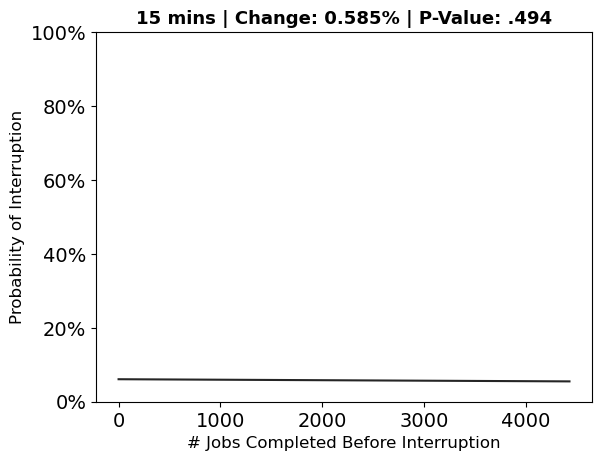

In [40]:

from matplotlib.ticker import FuncFormatter
fit_df = pd.DataFrame({
        'JobEndCount': np.linspace(start = job_errors_15min['JobEndCount'].min(),
                                stop = job_errors_15min['JobEndCount'].max(),
                                num = 200)
        })
fit_df['fit'] = job_15min_log.predict(fit_df)
fontSize = 14
plt.figure(figsize=(4, 17))
ax = fit_df.plot(
    x="JobEndCount",
    y="fit",
    kind="line",
    color='Black',
    alpha = .855,
    legend=False
)
def to_percent(y, _):
    return f"{y * 100:.0f}%"
ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
plt.xticks(rotation=0, fontsize=fontSize)
plt.yticks(fontsize=fontSize)
plt.ylim(0, 1)
plt.xlabel('# Jobs Completed Before Interruption', fontsize = 12)
plt.ylabel('Probability of Interruption', fontsize = 12)
plt.title(f'15 mins | Change: {(fit_df["fit"].max() - fit_df["fit"].min()) * 100:.3f}% | P-Value: .494', fontsize = 13, fontweight = 'bold');
#plt.text(0.5, 1.03, f'Prediction P-Value: {0.04 }', fontsize=11, ha='center', transform=ax.transAxes)
# plt.savefig('../assets/log15min.png', dpi = 150);
job_15min_log.summary()


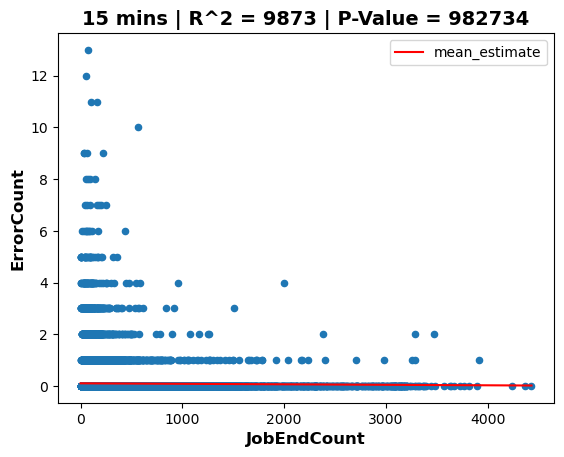

In [41]:
linreg_15 = smf.ols("ErrorCount ~ JobEndCount", data=job_errors_15min).fit()
linreg_15.summary()
pred_df = pd.DataFrame(
    {
        'JobEndCount': np.linspace(start=job_errors_15min['JobEndCount'].min(), stop=job_errors_15min['JobEndCount'].max())
    }
)

pred_df['mean_estimate'] = linreg_15.predict(pred_df)
pred_df
fig, ax = plt.subplots()
ax.set_title("15 mins | R^2 = 9873 | P-Value = 982734", fontsize=14, fontweight="bold")
ax.set_xlabel("Jobs Completed Before Interruption", fontsize=12, fontweight="bold")
ax.set_ylabel("Interruptions in timeframe", fontsize=12, fontweight="bold")

job_errors_15min.plot(kind="scatter", x="JobEndCount", y="ErrorCount", ax=ax)
pred_df.plot(kind="line", x="JobEndCount", y="mean_estimate", color="red", ax=ax);